In [1]:
import sys
sys.path.insert(0, "E:\\MSCProjects\\mobile-gaitlab\\training")

import numpy as np
import tensorflow as tf
import random as rn
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(1)
from tensorflow.keras import backend as K
tf.compat.v1.set_random_seed(1)
#sess = tf.Session(graph=tf.get_default_graph())
#K.set_session(sess)
import sys 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.regularizers
import scipy
import math
import sys
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
from scipy import interpolate
from scipy import signal
import pickle
from video_process_utils import *
import collections, re
import wandb
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TerminateOnNaN
from wandb.keras import WandbCallback

experiment_name="Random Score"
wandb.init(project="DystoniaColiation", entity="ubl", name=experiment_name)
pass

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ubl (use `wandb login --relogin` to force relogin)
e:\MSCProjects\mobile-gaitlab\.venv\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load Dataset

In [2]:
norm_df_fixed8 = pd.read_hdf("./norm_df_fixed8.hdf", key='han')
dataForLoop = norm_df_fixed8

In [3]:
GDRS= pd.read_excel("D:\DystoniaCoalition\dataset\P1.LV.Koirala.2021.3.30-2_edited.xlsx", sheet_name='GDRS', engine='openpyxl')
GDRS.columns
GDRS.drop(GDRS.columns[[1,2,3,4]],axis=1,inplace=True)
GDRS.rename(columns={ GDRS.columns[0]: "PID" }, inplace = True)
GDRS = GDRS.loc[:, ~GDRS.columns.str.startswith('Unnamed')].iloc[1:].reset_index(drop=True)
GDRS['PID'] = GDRS['PID'].apply(lambda x: re.findall("\d+", x)[0])

scores = GDRS[GDRS['PID'].isin(list(norm_df_fixed8[('Dystonia', 'PID')].unique().astype(str)))].iloc[:,5:6] #4:6
neck_scores = scores.values.reshape(-1).tolist()
neck_scores=  neck_scores

## FLip X axis

In [4]:
import random
clone  = norm_df_fixed8.copy()
clone.update(clone.loc[:,  clone.columns.get_level_values(1).isin(['x'])].apply(lambda x: -x))
clone[('Dystonia', "PID")] = clone[('Dystonia', "PID")].apply(lambda x: -x,)
norm_df_fixed8_Withflipped = norm_df_fixed8.append(clone)
dataForLoop = norm_df_fixed8_Withflipped

neck_scores_Withflipped =  neck_scores
neck_scores_Withflipped.extend(neck_scores)
y= neck_scores_Withflipped

# y= [random.randint(0,9) for i in range(len(y))]  #ramdom score to test 

In [7]:
X = []
for name, _df in dataForLoop.groupby(('Dystonia','PID')):
    eachVideo = []
    for _name, row in _df.iterrows():
        eachVideo.append(list(row.iloc[2:18]))
    X.append(eachVideo)
X=np.array(X)

In [8]:
from sklearn.model_selection import train_test_split
# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.00, stratify=y, random_state=42)
# pd.Series(list(y_train)).value_counts()

X_train = tf.convert_to_tensor(X, dtype=tf.float32)
y_train = tf.convert_to_tensor(y, dtype=tf.float32)
X_validation = tf.convert_to_tensor(X, dtype=tf.float32)
y_validation = tf.convert_to_tensor(y, dtype=tf.float32)

In [9]:
target_range=10
target_column="Neck"

In [47]:
def step_decay(initial_lrate,epochs_drop,drop_factor):
    def step_decay_fcn(epoch):
        return max(initial_lrate * math.pow(drop_factor, math.floor((1+epoch)/epochs_drop)), 0.002)
    return step_decay_fcn

epochs_drop,drop_factor = (20,0.8)
initial_lrate = 0.01
dropout_amount = 0.1  # overfit in training
last_layer_dim = 10
filter_length = 8
conv_dim = 32
l2_lambda = 10**(-3.5)

def w_mse(weights):
    def loss(y_true, y_pred):
        #multiply by len(weights) to make the magnitude invariant to number of components in target
        return K.mean(K.sum(K.square(y_true-y_pred)*weights,axis=1)*tf.reshape(y_true[:,-1],(-1,1)))
    return loss

#we don't want to optimize for the column counting video occurences of course, but
#they are included in the target so we can use that column for the loss function
weights = [1.0]
normal_weights = [1.0]


#normalize weights to sum to 1 to prevent affecting loss function
weights = weights/np.sum(weights)
normal_weights = normal_weights/np.sum(normal_weights)

mse_opt = w_mse(weights)

#monitor our actual objective
mse_metric = w_mse(target_range**2*normal_weights)

hyper_str = "params_"
for param in [initial_lrate,epochs_drop,drop_factor,dropout_amount,conv_dim,last_layer_dim,filter_length,l2_lambda]:
    hyper_str = hyper_str + str(param) + "_"

n_epochs = 100

wandb.config.update({
"epochs": n_epochs,
"epochs_drop,drop_factor" : (epochs_drop,drop_factor),
"initial_lrate" : initial_lrate,
"dropout_amount" : dropout_amount,
"last_layer_dim" : last_layer_dim,
"filter_length" : filter_length,
"conv_dim" : conv_dim,
"l2_lambda" : l2_lambda,
})

K.clear_session()
#K.set_session(sess)

model = Sequential(name="Neck_model")
model.add(Conv1D(conv_dim,filter_length ,padding='same')) # input_dim=X_train.shape[2],input_length=vid_length
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv1D(conv_dim,filter_length,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv1D(conv_dim,filter_length,padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv1D(conv_dim,filter_length,padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv1D(conv_dim,filter_length,padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv1D(conv_dim,filter_length,padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(dropout_amount))
model.add(Flatten())
model.add(Dense(last_layer_dim,activation='relu'))
model.add(Dense(1, activation='linear'))

In [80]:
opt = RMSprop(lr=0.0,rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss=mse_opt,metrics=[mse_metric],
                optimizer=opt)

lr = LearningRateScheduler(step_decay(initial_lrate,epochs_drop,drop_factor))

history = model.fit(X_train, y_train,callbacks=[
    lr,
    TerminateOnNaN(), WandbCallback()],
            validation_data=(X_validation,y_validation),
            batch_size=400, epochs=n_epochs,
            shuffle=True,
            )

Epoch 1/100
2/2 [==============================] - 0s 208ms/step - loss: 509.7854 - val_loss: 1193.5706
Epoch 2/100
2/2 [==============================] - 0s 122ms/step - loss: 783.6105 - val_loss: 284.1475
Epoch 3/100
2/2 [==============================] - 0s 146ms/step - loss: 256.8203 - val_loss: 130.2187
Epoch 4/100
2/2 [==============================] - 0s 100ms/step - loss: 130.6626 - val_loss: 124.8750
Epoch 5/100
2/2 [==============================] - 0s 96ms/step - loss: 126.0093 - val_loss: 108.6517
Epoch 6/100
2/2 [==============================] - 0s 120ms/step - loss: 186.7793 - val_loss: 243.6836
Epoch 7/100
2/2 [==============================] - 0s 139ms/step - loss: 191.9925 - val_loss: 75.9501
Epoch 8/100
2/2 [==============================] - 0s 136ms/step - loss: 114.9955 - val_loss: 54.8665
Epoch 9/100
2/2 [==============================] - 0s 94ms/step - loss: 121.6227 - val_loss: 129.6591
Epoch 10/100
2/2 [==============================] - 0s 94ms/step - loss: 148

In [81]:
print("done")

done


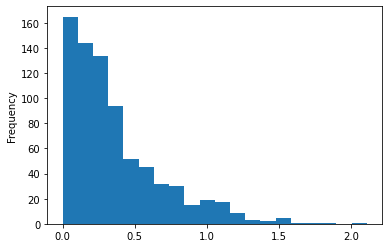

In [82]:
my_dict = {
    'PID': [name for name, _df in dataForLoop.groupby(('Dystonia','PID'))],
    'Prediction': list(model.predict(X_train).flatten()),
    'Original': list(y_train.numpy())
}

result = pd.DataFrame(my_dict)

result['diff'] = np.abs(result['Original'] - result['Prediction'])
result['Prediction'] = np.abs(result['Prediction'].astype(int))


result.sort_values(by=['diff']).head(60)
# result
# list(y_train.numpy())

result['diff'].plot(kind='hist',bins=20)